# DOPP 2019W Exercise 3 - Group 32

### Contributors
- Eszter Katalin Bognar - 11931695
- Luis Kolb - 01622731
- Alexander Leitner - 01525882

### Objectives of the analysis
- What is the most accurate overview of flows of refugees between countries that can be obtained? 
- Are there typical characteristics of refugee origin and destination countries? 
- Are there typical characteristics of large flows of refugees? 
- Can countries that will produce large numbers of refugees be predicted? Can refugee flows be predicted?

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import logging

pd.options.mode.chained_assignment = None  # default='warn'

pd.options.mode.chained_assignment = None  # default='warn'
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

from sklearn import svm
from sklearn import neighbors
from sklearn import tree
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import PolynomialFeatures

## Load datasets
We started our analysis by loading the necessary data files.

We selected 4 datasets to use:
- OECD International Migration Database data (https://stats.oecd.org/Index.aspx?DataSetCode=MIG)
- Gross Domestic Product per Capita data (https://data.worldbank.org/indicator/NY.GDP.PCAP.CD)
- Human Development Index data (http://hdr.undp.org/en/data)
- World Governance Index data (https://datacatalog.worldbank.org/dataset/worldwide-governance-indicators)

Each dataset were loaded and formatted including:

- reshaping columns (changing rows to columns or columns to rows when necessary),
- getting rid of unwanted columns, 
- renaming columns, 
- setting proper data types,
- setting country-year multiindex to facilitate future data merge.

In [3]:
'''
Load & format OECD International Migration Database data
'''

def load_oecd_data():
    """ 
    Load oecd data file
    Reshape the dataset to have country, destination, year, asylum_seekers and migrants columns
    Set hierarchical index (country, year)
    
    Returns
    --------
    oecd: data frame containing oecd data
    """
    #load dataset
    oecd = pd.read_csv('data/oecd_data.csv',na_values=['..'])
    #reshape table
    oecd.set_index(['country','destination', 'year','variable'], inplace=True)
    oecd=oecd.unstack()
    oecd.columns = oecd.columns.droplevel(0)
    #drop unwanted columns
    oecd.reset_index(drop=False, inplace=True)
    #rename columns
    oecd = oecd[['country','destination','year','Inflows of asylum seekers by nationality','Inflows of foreign population by nationality']]
    oecd = oecd.rename(columns={'Inflows of asylum seekers by nationality': 'asylum_seekers', 'Inflows of foreign population by nationality': 'migrants'})
    #set index
    oecd=oecd.set_index(['country', 'year'])
    return oecd

oecd_df=load_oecd_data()
oecd_df.info()
oecd_df.head(50)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 28525 entries, (Afghanistan, 2000) to (Côte d'Ivoire, 2017)
Data columns (total 3 columns):
destination       28525 non-null object
asylum_seekers    19395 non-null float64
migrants          19349 non-null float64
dtypes: float64(2), object(1)
memory usage: 724.9+ KB


variable         destination  asylum_seekers  migrants
country     year                                      
Afghanistan 2000   Australia          1326.0     887.0
            2001   Australia          2161.0     456.0
            2002   Australia            53.0     660.0
            2003   Australia            54.0    1015.0
            2004   Australia           116.0    1340.0
            2005   Australia            32.0    3463.0
            2006   Australia            21.0    3465.0
            2007   Australia            20.0    2560.0
            2008   Australia            52.0    2033.0
            2009   Australia           940.0    1696.0
            2010   Australia          1265.0    1618.0
            2011   Australia          1720.0    2030.0
            2012   Australia          3064.0    1623.0
            2013   Australia           370.0    2178.0
            2014   Australia           123.0    5686.0
            2015   Australia           567.0    3323.0
            2016   Australia          2563.0    3197.0
            2017   Australia          1478.0    3566.0
            2000     Austria          4205.0     828.0
            2001     Austria         12955.0    1539.0
            2002     Austria          6651.0    1101.0
            2003     Austria          2357.0     743.0
            2004     Austria           757.0     650.0
            2005     Austria           923.0     652.0
            2006     Austria           699.0     498.0
            2007     Austria           761.0     530.0
            2008     Austria          1382.0     958.0
            2009     Austria          2237.0    1422.0
            2010     Austria          1582.0    1281.0
            2011     Austria          3609.0    2908.0
            2012     Austria          4003.0    3756.0
            2013     Austria          2589.0    2305.0
            2014     Austria          4916.0    3171.0
            2015     Austria         25143.0   19505.0
            2016     Austria         11506.0   11660.0
            2017     Austria          3525.0    2103.0
            2000     Belgium           861.0       NaN
            2001     Belgium           504.0       NaN
            2002     Belgium           326.0       NaN
            2003     Belgium           329.0       NaN
            2004     Belgium           287.0       NaN
            2005     Belgium           253.0       NaN
            2006     Belgium           365.0       NaN
            2007     Belgium           696.0       NaN
            2008     Belgium           879.0     138.0
            2009     Belgium          1659.0     150.0
            2010     Belgium          1124.0     208.0
            2011     Belgium          2774.0     285.0
            2012     Belgium          2349.0    2804.0
            2013     Belgium           892.0    1255.0

In [4]:
'''
Load & format Gross Domestic Product per Capita data
'''

def load_gdp_data():
    """ 
    Load gdp data file
    Reshape the dataset to have country, year, GDP columns
    Change data types
    Set hierarchical index (country, year)
    
    Returns
    --------
    gdp: data frame containing gdp data
    """
    #load dataset
    gdp = pd.read_csv('data/GDPPC_data.csv',na_values=['..'])
    #drop unwanted columns
    gdp.drop(['Indicator Name','Indicator Code','Country Code' ], inplace=True, axis=1)
    #reshape dataframe
    gdp.set_index(['Country Name'], inplace=True)
    gdp=gdp.stack(dropna=False).to_frame()
    gdp.reset_index(drop=False, inplace=True)
    #rename columns
    gdp=gdp.rename(columns={'Country Name': 'country', 'level_1': 'year', 0: 'GDP'})
    #set datatype for year, GDP
    gdp['year']=gdp['year'].astype(int)
    gdp['GDP']=gdp['GDP'].astype(float)
    #only use data from 2000 onwards
    gdp = gdp[gdp.year >= 2000]
    #set index
    gdp=gdp.set_index(['country', 'year'])
    return gdp

gdp_df=load_gdp_data()
gdp_df.info()
gdp_df.tail(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 5280 entries, (Aruba, 2000) to (Zimbabwe, 2019)
Data columns (total 1 columns):
GDP    4738 non-null float64
dtypes: float64(1)
memory usage: 59.1+ KB


GDP
country  year             
Zimbabwe 2010   948.331854
         2011  1093.654002
         2012  1304.969802
         2013  1430.000818
         2014  1434.899340
         2015  1445.071062
         2016  1464.583529
         2017  1602.403507
         2018  2146.996385
         2019          NaN

In [5]:
'''
Load & format Human Development Index data
'''

def load_hdi_data():
    """ 
    Load hdi data file
    Reshape the dataset to have country, year, HDI columns
    Change data types
    Set hierarchical index (country, year)
    
    Returns
    --------
    hdi: data frame containing hdi data
    """
    #load dataset
    hdi = pd.read_csv('data/HDI.csv',na_values=['..'])
    #drop unwanted columns
    hdi.drop(['HDI Rank (2018)'], inplace=True, axis=1)
    #reshape dataframe
    hdi.set_index(['Country'], inplace=True)
    hdi=hdi.stack(dropna=False).to_frame()
    hdi.reset_index(drop=False, inplace=True)
    #rename columns
    hdi=hdi.rename(columns={'Country': 'country', 'level_1': 'year', 0: 'HDI'})
    #set datatype for year
    hdi['year']=hdi['year'].astype(int)
    hdi['HDI']=hdi['HDI'].astype(float)
    #only use data from 2000 onwards
    hdi = hdi[hdi.year >= 2000]
    #set index
    hdi=hdi.set_index(['country', 'year'])
    return hdi

hdi_df=load_hdi_data()
hdi_df.info()
hdi_df.head(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 4028 entries, (Afghanistan, 2000) to (World, 2018)
Data columns (total 1 columns):
HDI    3788 non-null float64
dtypes: float64(1)
memory usage: 45.2+ KB


HDI
country     year       
Afghanistan 2000  0.345
            2001  0.347
            2002  0.378
            2003  0.387
            2004  0.400
            2005  0.410
            2006  0.419
            2007  0.431
            2008  0.436
            2009  0.447

In [6]:
'''
Load & format World Governance Index data
'''

def load_wgi_data():
    """ 
    Load wgi data file
    Reshape the dataset to have country, year, WGI columns
    Change data types
    Set hierarchical index (country, year)
    
    Returns
    --------
    hdi: data frame containing hdi data
    """
    #load dataset
    wgi = pd.read_csv('data/WGIData.csv',na_values=['..'])
    #drop unwanted rows
    wgi=wgi[wgi['Indicator Code'].str.contains('EST', regex= True, na=False)]
    #drop unwanted columns
    wgi.drop(['Country Code','Indicator Name'], inplace=True, axis=1)
    #reshape dataframe
    wgi.set_index(['Country Name','Indicator Code'], inplace=True)
    wgi=wgi.stack(dropna=False).to_frame()
    wgi.reset_index(drop=False, inplace=True)
    #rename columns
    wgi=wgi.rename(columns={'Country Name': 'country', 'level_2': 'year', 0: 'variable'})
    wgi.set_index(['country','year','Indicator Code'], inplace=True)
    wgi=wgi.unstack()
    wgi.columns = wgi.columns.droplevel(0)
    wgi.reset_index(drop=False, inplace=True)
    #set datatype for year 
    wgi['year']=wgi['year'].astype(int)
    #only use data from 2000 onwards
    wgi = wgi[wgi.year >= 2000]
    #set index
    wgi=wgi.set_index(['country', 'year'])
    return wgi
wgi_df=load_wgi_data()
wgi_df.info()
wgi_df.head(10)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3852 entries, (Afghanistan, 2000) to (Zimbabwe, 2018)
Data columns (total 6 columns):
CC.EST    3730 non-null float64
GE.EST    3720 non-null float64
PV.EST    3734 non-null float64
RL.EST    3769 non-null float64
RQ.EST    3719 non-null float64
VA.EST    3737 non-null float64
dtypes: float64(6)
memory usage: 193.8+ KB


Indicator Code      CC.EST    GE.EST    PV.EST    RL.EST    RQ.EST    VA.EST
country     year                                                            
Afghanistan 2000 -1.295380 -2.231651 -2.440187 -1.778437 -2.109626 -2.031417
            2002 -1.263366 -1.567973 -2.035389 -1.670823 -1.804449 -1.433421
            2003 -1.351042 -1.082488 -2.197809 -1.553829 -1.430002 -1.177571
            2004 -1.345281 -0.894051 -2.296179 -1.697143 -1.505863 -1.203034
            2005 -1.443609 -1.210829 -2.070934 -1.658668 -1.637369 -1.125430
            2006 -1.432890 -1.430343 -2.221302 -1.863189 -1.667902 -1.110294
            2007 -1.587331 -1.403352 -2.410581 -1.829666 -1.688257 -1.057654
            2008 -1.638287 -1.496089 -2.690477 -1.864380 -1.621583 -1.168902
            2009 -1.534796 -1.483899 -2.712689 -1.847092 -1.674311 -1.375497
            2010 -1.635723 -1.454683 -2.579152 -1.845436 -1.532861 -1.404468

## Country name inconsistency check 
Before data merge we have to check the datasets for inconsistencies. 
We would like to merge on the country-year multiindex.
Year is consistent in each data files however we have to search for different usage and typos in county names.
We selected oecd_df as base dataframe so we compare the country names in the oecd_df to the country names in the hdi_df, gdp_df, wgi_df datasets.

In [7]:
def country_check(countries, gdp_df, hdi_df, wgi_df):
    """ 
    Parameters
    --------
    countries: list of countries (source or destination) in oecd_df
    gdp_df: gdp of the countries
    hdi_df: hdi of the countries
    wgi_df: wgi data of the countries
    
    Returns
    --------
    check: dataframe showing inconsistent country name usage
    """   
    #get country name list series
    hdi_c = hdi_df.index.unique(level=0).to_series()
    gdp_c = gdp_df.index.unique(level=0).to_series()
    wgi_c = wgi_df.index.unique(level=0).to_series()
    
    #create dataframe for the results
    check=pd.DataFrame(columns=['country','hdi','gdp','wgi'])
    #iterate through oecd_df source or destination country names and check presence of country name in other dfs
    for index,row in countries.iterrows():
        check=check.append({'country': row.country,
                            'hdi':row.isin(hdi_c).values[0],
                           'gdp':row.isin(gdp_c).values[0],
                           'wgi':row.isin(wgi_c).values[0]}, ignore_index=True)
        
    #add only problematic country rows to the result df
    check=check.loc[(check['hdi'] == False) | (check['gdp'] == False) | (check['wgi'] == False)]
    return check

oecd_s = pd.DataFrame(oecd_df.index.unique(level=0))
oecd_s_check = country_check(oecd_s,gdp_df, hdi_df, wgi_df)

oecd_d = pd.DataFrame(oecd_df['destination'].unique(),columns={'country'})
oecd_d_check = country_check(oecd_d,gdp_df, hdi_df, wgi_df)

display(oecd_d_check.head(50),oecd_s_check.head(50))
df = pd.concat([oecd_d_check,oecd_s_check])

,country,hdi,gdp,wgi
5,Czech Republic,False,True,True
18,Korea,False,False,False
27,Slovak Republic,False,True,True


,country,hdi,gdp,wgi
11,Bahamas,True,False,False
19,Bermuda,False,True,True
21,Bolivia,False,True,True
32,Cape Verde,False,False,False
39,Congo,True,False,False
40,Cook Islands,False,False,True
45,Côte d'Ivoire,True,False,False


For making the country names consistent, we first tried out the fuzzy search method of the fuzzywuzzy library. 
Due to errors, we finally decided to manually create a dictonary of country names to replace or delete them.

In [8]:
country_dict = {
    'Bahamas, The' :"Bahamas",
    'Bolivia (Plurinational State of)' :"Bolivia",
    'Cabo Verde' :"Cape Verde",
    'Congo, Rep.' :"Congo",
    'Czechia' :"Czech Republic",
    "Cote d'Ivoire" :"Côte d'Ivoire",
    'Congo, Dem. Rep.' :"Democratic Republic of the Congo",
    'Congo (Democratic Republic of the)':"Democratic Republic of the Congo",
    'Egypt, Arab Rep.' :"Egypt",
    'Gambia, The' :"Gambia",
    'Iran (Islamic Republic of)' :"Iran",
    'Iran, Islamic Rep.': "Iran",
    'Korea (Republic of)' :"Korea",
    'Korea, Rep.':"Korea",
    'Kyrgyz Republic' :"Kyrgyzstan",
    "Lao People's Democratic Republic" :"Laos",
    "Lao PDR":"Laos",
    'Micronesia (Federated States of)' :"Micronesia",
    'Micronesia, Fed. Sts.':'Micronesia',
    'Moldova (Republic of)' :"Moldova",
    'Russian Federation' :"Russia",
    'St. Kitts and Nevis' :"Saint Kitts and Nevis",
    'St. Lucia' :"Saint Lucia",
    'St. Vincent and the Grenadines' :"Saint Vincent and the Grenadines",
    'Slovakia' :"Slovak Republic",
    'Syrian Arab Republic' :"Syria",
    'Eswatini' :"Swaziland",
    "Eswatini (Kingdom of)": "Swaziland",
    'Tanzania (United Republic of)' :"Tanzania",
    'Venezuela (Bolivarian Republic of)' :"Venezuela",
    "Venezuela, RB":"Venezuela",
    'Vietnam' :"Viet Nam",
    'Yemen, Rep.' :"Yemen"  
}

country_del = [
#former countries
"Former Czechoslovakia",
"Former USSR",
"Former Yugoslavia",
"Serbia and Montenegro",
#China' territory
"Macau",
"Chinese Taipei",
"Hong Kong, China",
#USA's territory 
"Guam",
"Puerto Rico",
#GB' territory
"Bermuda",
#New Zealand' territory
"Cook Islands",
"Tokelau",
"Niue",
#Palestina's territory
"West Bank and Gaza Strip",
#no proper data
"Nauru",
"San Marino",
"Somalia",
"Tuvalu",
"Democratic People's Republic of Korea",
"Monaco",
"Not stated",
"Unknown",
"Total",
]

def country_correction(df):
    """ 
    Parameters
    --------
    df: dataframe with original country names

    Returns
    --------
    df_corrected: data frame with replaced country names
    """
    #rename country names  
    df_corrected=df.rename(index=country_dict, level=0)
    return df_corrected

#delete unwanted countries from the oecd_df base df
oecd_df=oecd_df.drop(country_del, level=0, errors='ignore')

#call country_correction() to rename country names
hdi_df=country_correction(hdi_df)
gdp_df=country_correction(gdp_df)
wgi_df=country_correction(wgi_df)


#check for inconsistencies again
countries = pd.DataFrame(oecd_df.index.unique(level=0))
oecd_check = country_check(countries,gdp_df, hdi_df, wgi_df)

if oecd_check.empty:
    print("No more inconsistent country names!")

No more inconsistent country names!


## Outlier detection
We checked the distribution of hdi, wgi and gdp data showing there are more poor than wealthy countries...We can not see any outliers. GDP is skewed towards zero, HDI is in the range of [0-1], wgi metrics are in the range of [-2-2].

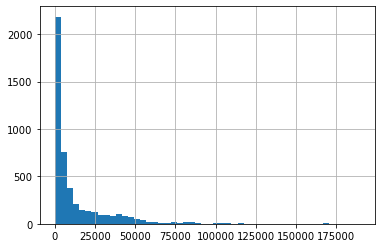

In [9]:
gdp_df['GDP'].hist(bins=50)

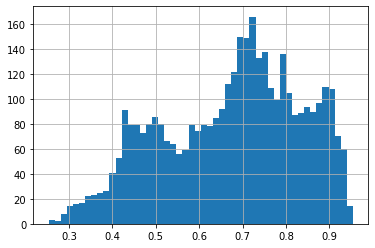

In [10]:
hdi_df['HDI'].hist(bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f18dbd53f60>,
      dtype=object)

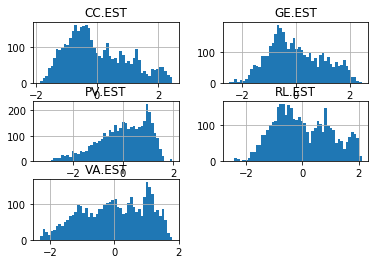

In [11]:
wgi_df[['CC.EST','GE.EST','PV.EST','RL.EST','VA.EST']].hist(bins=50)

## Handling missing values
After resolving the country name inconsistency and outlier check, we moved forward to examine outliers and missing values in the data files. We started with the visual analysis of the datasets to identify problematic areas, then implemented our solution to handle them. 

In [12]:
#investigating occurences of missing values in the hdi dataset
display(hdi_df.isnull().sum())
display(gdp_df.isnull().sum())
display(wgi_df.isnull().sum())

HDI    240
dtype: int64

GDP    542
dtype: int64

Indicator Code
CC.EST    122
GE.EST    132
PV.EST    118
RL.EST     83
RQ.EST    133
VA.EST    115
dtype: int64

Since the hdi, gdp and wgi indicators don't change rapidly from year to year we interpolated missing data from previous and next data using pandas interpolate method.

In [13]:
def handle_missingValues(incomplete_data):
    """ 
    Parameters
    --------
    incomplete_data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    # YOUR CODE HERE
    #filling missing values with interpolation  
    columns=incomplete_data.columns
    for col in columns:
        incomplete_data[col].interpolate('linear', inplace=True,limit_direction='both')
    complete_data=incomplete_data       
    return complete_data
hdi_complete=handle_missingValues(hdi_df)
gdp_complete=handle_missingValues(gdp_df)
wgi_complete=handle_missingValues(wgi_df)

display(hdi_complete.isnull().sum())
display(gdp_complete.isnull().sum())
display(wgi_complete.isnull().sum())

HDI    0
dtype: int64

GDP    0
dtype: int64

Indicator Code
CC.EST    0
GE.EST    0
PV.EST    0
RL.EST    0
RQ.EST    0
VA.EST    0
dtype: int64

In [14]:
def merge_dest(s_merged, gdp_df, hdi_df, wgi_df):
    """ 
    Parameters
    --------
    s_merged: merged dataset with values for the source country
    gdp_df: gdp of the countries
    hdi_df: hdi of the countries
    wgi_df: wgi data of the countries
    
    Returns
    --------
    d_merged: merged data frame that contains complete migration and country data for the source and destination countries
    """
    s_merged = s_merged.rename(columns={'destination': 'country'})
    s_merged=s_merged.set_index(['year','country'])
    merge1=pd.merge(gdp_df, hdi_df, on=['year', 'country'])
    merge2=pd.merge(merge1, wgi_df, on=['year', 'country'])
    d_merged=pd.merge(merge2,s_merged,on=['year','country'])
    d_merged=d_merged.reset_index()
    d_merged = d_merged.rename(columns={'GDP': 'd_GDP',
                                             'HDI': 'd_HDI',
                                             'CC.EST': 'd_CC.EST',
                                             'GE.EST': 'd_GE.EST',
                                             'PV.EST': 'd_PV.EST',
                                             'RL.EST': 'd_RL.EST',
                                             'VA.EST': 'd_VA.EST',
                                             'country': 'destination'})
    return d_merged


def merge_data(oecd_df, gdp_df, hdi_df, wgi_df):
    """ 
    Parameters
    --------
    oecd_df: yearly data for foreign population inflow and asylum seeker inflow from source to destination country
    gdp_df: gdp of the countries
    hdi_df: hdi of the countries
    wgi_df: wgi data of the countries
    
    Returns
    --------
    merged_data: merged data frame that contains complete migration and country data
    
    """
    merge1=pd.merge(gdp_df, hdi_df, on=['year', 'country'])
    merge2=pd.merge(merge1, wgi_df, on=['year', 'country'])
    s_merged=pd.merge(merge2,oecd_df,on=['year','country'])
    s_merged=s_merged.reset_index()
    s_merged = s_merged.rename(columns={'GDP': 's_GDP',
                                             'HDI': 's_HDI',
                                             'CC.EST': 's_CC.ESTP',
                                             'GE.EST': 's_GE.EST',
                                             'PV.EST': 's_PV.EST',
                                             'RL.EST': 's_RL.EST',
                                             'VA.EST': 's_VA.EST',
                                             'country': 'source'})
    merged_data=merge_dest(s_merged,gdp_df, hdi_df, wgi_df)
    #set multiindex with year, source, destination
    merged_data=merged_data.set_index(['year','source'])
    
    return merged_data

data_merged = merge_data(oecd_df, gdp_df, hdi_df, wgi_df)
data_merged.to_csv("merged.csv")
data_merged.info()
data_merged

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 25750 entries, (2000, Afghanistan) to (2017, Chad)
Data columns (total 19 columns):
destination       25750 non-null object
d_GDP             25750 non-null float64
d_HDI             25750 non-null float64
d_CC.EST          25750 non-null float64
d_GE.EST          25750 non-null float64
d_PV.EST          25750 non-null float64
d_RL.EST          25750 non-null float64
RQ.EST_x          25750 non-null float64
d_VA.EST          25750 non-null float64
s_GDP             25750 non-null float64
s_HDI             25750 non-null float64
s_CC.ESTP         25750 non-null float64
s_GE.EST          25750 non-null float64
s_PV.EST          25750 non-null float64
s_RL.EST          25750 non-null float64
RQ.EST_y          25750 non-null float64
s_VA.EST          25750 non-null float64
asylum_seekers    18274 non-null float64
migrants          18026 non-null float64
dtypes: float64(18), object(1)
memory usage: 3.8+ MB


destination        d_GDP  d_HDI  d_CC.EST  d_GE.EST  \
year source                                                               
2000 Afghanistan      Australia  21679.24784  0.898  1.923246  1.810187   
     Angola           Australia  21679.24784  0.898  1.923246  1.810187   
     Albania          Australia  21679.24784  0.898  1.923246  1.810187   
     Andorra          Australia  21679.24784  0.898  1.923246  1.810187   
     Argentina        Australia  21679.24784  0.898  1.923246  1.810187   
...                         ...          ...    ...       ...       ...   
2017 Cuba         United States  59927.92983  0.919  1.381242  1.554298   
     Algeria      United States  59927.92983  0.919  1.381242  1.554298   
     Croatia      United States  59927.92983  0.919  1.381242  1.554298   
     Cambodia     United States  59927.92983  0.919  1.381242  1.554298   
     Chad         United States  59927.92983  0.919  1.381242  1.554298   

                  d_PV.EST  d_RL.EST  RQ.EST_x  d_VA.EST         s_GDP  s_HDI  \
year source                                                                     
2000 Afghanistan  1.334552  1.751407  1.637249  1.471305  10359.762493  0.345   
     Angola       1.334552  1.751407  1.637249  1.471305    556.836318  0.394   
     Albania      1.334552  1.751407  1.637249  1.471305   1126.683318  0.667   
     Andorra      1.334552  1.751407  1.637249  1.471305  21936.530100  0.759   
     Argentina    1.334552  1.751407  1.637249  1.471305   7708.100996  0.770   
...                    ...       ...       ...       ...           ...    ...   
2017 Cuba         0.335553  1.644761  1.628115  1.049652   8541.210673  0.777   
     Algeria      0.335553  1.644761  1.628115  1.049652   4044.298372  0.758   
     Croatia      0.335553  1.644761  1.628115  1.049652  13412.341950  0.835   
     Cambodia     0.335553  1.644761  1.628115  1.049652   1385.458363  0.578   
     Chad         0.335553  1.644761  1.628115  1.049652    664.303316  0.401   

                  s_CC.ESTP  s_GE.EST  s_PV.EST  s_RL.EST  RQ.EST_y  s_VA.EST  \
year source                                                                     
2000 Afghanistan  -1.295380 -2.231651 -2.440187 -1.778437 -2.109626 -2.031417   
     Angola       -1.522685 -1.462310 -2.035583 -1.663307 -1.799331 -1.458065   
     Albania      -0.857256 -0.755118 -0.537979 -1.008780 -0.254359 -0.285139   
     Andorra       1.359712  1.446284  1.167002  1.312131  1.276005  1.535655   
     Argentina    -0.192119  0.032177  0.099359 -0.149923  0.257245  0.418347   
...                     ...       ...       ...       ...       ...       ...   
2017 Cuba          0.265626 -0.181841  0.646901 -0.431357 -1.329062 -1.551914   
     Algeria      -0.604175 -0.589159 -0.915669 -0.863938 -1.196304 -0.904877   
     Croatia       0.186701  0.571306  0.691869  0.334248  0.424106  0.511416   
     Cambodia     -1.291381 -0.658138  0.091168 -1.056137 -0.502938 -1.155918   
     Chad         -1.432357 -1.469803 -1.287330 -1.295343 -1.210235 -1.372231   

                  asylum_seekers  migrants  
year source                                 
2000 Afghanistan          1326.0     887.0  
     Angola                  3.0       5.0  
     Albania                59.0      64.0  
     Andorra                 NaN       0.0  
     Argentina               3.0      84.0  
...                          ...       ...  
2017 Cuba                  730.0   65028.0  
     Algeria               121.0    2139.0  
     Croatia                 NaN     375.0  
     Cambodia                NaN    4056.0  
     Chad                    NaN     205.0  

[25750 rows x 19 columns]

#check=data_merged.reset_index()
#check[(check['source']=='Eritrea') & (check['year']==2000)]

### Predictions
In this section we try to predict the refugee flow and see if this is possible.

In [15]:
def load_ref_data_predict():
    #data = pd.DataFrame()
    data = data_merged
    data = data_merged.reset_index()
    # print columns
    
    cols_to_drop = ["destination","source","d_VA.EST","d_GDP","d_HDI","d_CC.EST","d_GE.EST","d_PV.EST","d_RL.EST","RQ.EST_x","s_GDP","s_HDI","s_CC.ESTP","s_GE.EST","s_PV.EST","s_RL.EST","s_RL.EST","RQ.EST_y","s_VA.EST","migrants"] 
    #s_HDI s_CC.ESTP s_GE.EST s_PV.EST s_RL.EST RQ.EST_y s_VA.EST['migrants']
    data = data.drop(cols_to_drop, axis = 1)
    
    ref_data_pred = data[data.year == 2017]
    ref_data_pred.dropna(how='any', inplace=True)
    
    
    ref_data = data[data.year != 2017]
    
    ref_data.dropna(how='any', inplace=True)
    ref_data_pred.dropna(how='any', inplace=True)
    
    #ref_data_pred = data[data.year == 2017]
    #ref_data_pred.dropna(how='any', inplace=True)
    
    
    #ref_data = data[data.year != 2017]
    
    #logger.info(data)
    #data.drop(data.year == 2018 , inplace=True)
    
    #print(data)
    # split the week column (drop the .Woche part)
    #data['week'], data['week_del'] = data['Kalenderwoche'].str.split('.', 1).str
    # print(data)
    # drop some columns
    #print('1.step: ',data)
    #cols_to_drop = ['ID', 'BEZEICHNUNG', 'Grippesaison ', 'Schwankungsbreite', 'week_del', 'Kalenderwoche']
    #data = data.drop(cols_to_drop, axis = 1)
    #print('2.step: ',data)
    #data.rename(columns = {'Neuerkrankungen pro Woche': 'weekly_infections',
                           #'Jahr' : 'year', 'Kalenderwoche' : 'week'}, inplace = True)
    #data['weekly_infections'].replace("-",0, inplace=True)                             
    #data['weekly_infections'] = pd.to_numeric(data['weekly_infections'])
    #data.set_index(['year', 'week'], inplace = True)
    #data.index.set_names(['year',  'week'], inplace = True)
    #print('3.step: ',data)
    #influenza_data_predict = data
  
    
    
    return ref_data_pred,ref_data
load_ref_data_predict()

(       year  asylum_seekers
 704    2017          1478.0
 718    2017           462.0
 734    2017          6638.0
 1452   2017          3525.0
 1453   2017            15.0
 ...     ...             ...
 25740  2017           411.0
 25741  2017          3204.0
 25744  2017           111.0
 25745  2017           730.0
 25746  2017           121.0
 
 [453 rows x 2 columns],        year  asylum_seekers
 0      2000          1326.0
 1      2000             3.0
 2      2000            59.0
 4      2000             3.0
 5      2000            14.0
 ...     ...             ...
 25702  2016           147.0
 25703  2016            63.0
 25704  2016             3.0
 25705  2016            11.0
 25706  2016            53.0
 
 [17821 rows x 2 columns])

In [17]:
real,ref_pre_data = load_ref_data_predict() 
 
descriptors = ref_pre_data[["year" , "asylum_seekers"]]
target = ref_pre_data[["asylum_seekers"]]

np.random.seed(seed=12345) # get allways the same random generator
msk = np.random.rand(len(descriptors)) <= 0.85 # mask to split the dataset into the training and test set
# for 10 fold cross validation we would need to make more splits like 0.95, 0.85, 0.75, ...
training_data = descriptors[msk]
test_data = descriptors[~msk]
training_target = target[msk]
test_target = target[~msk]


# Linear Regression
# I am using regression, because I have to predict a real number / integer which is not possible using the classification methods

reg = LinearRegression().fit(training_data, training_target) # learn how the data looks like


#logger.debug(reg.score(training_data,training_target)) # predict and evaluate
#reg.predict(test_data) # predict
#logger.info(reg.score(test_data,test_target)) #evaluate

#Lasso Regression

#make parameters list
normalize = [False, True]
intercept = [True, False]
alpha = [0, 1e-15, 1e-10, 1e-5, 1, 5, 10, 15]
results = [] # to collect the results

#loop through all possible parameter combinations
for n in normalize:
    for inter in intercept:
        for a in alpha:
            result_row = {}

            result_row["normalize"] = n
            result_row["intercept"] = inter
            result_row["alpha"] = a

            lasso = Lasso(alpha=a, fit_intercept=inter, normalize=n) # create the regressor

            lasso.fit(training_data, training_target)
            predicted = lasso.predict(test_data)

            result_row["score"] = round(lasso.score(test_data,test_target["asylum_seekers"]), 4)
            results.append(result_row)
#logger.info(pd.DataFrame(results)) # look over the result list to find the best parameters for machine learning

# Linear Regression revisited - as for the Lasso Regression
normalize = [False, True]
bias = [False, True]
interaction = [False, True]
intercept = [True, False]
degree = [ 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16 ]
results = []
for n in normalize:
    for b in bias:
        for interact in interaction:
            for inter in intercept:
                for d in degree:

                    result_row = {}
                    result_row["normalize"] = n
                    result_row["bias"] = b
                    result_row["interaction"] = interact
                    result_row["intercept"] = inter
                    result_row["degree"] = d

                    poly = PolynomialFeatures(include_bias=b, interaction_only=interact, degree=d)
                    lrm = LinearRegression(normalize=n, fit_intercept=inter)
                    X_poly=poly.fit_transform(training_data)
                    X_p_poly=poly.fit_transform(test_data)
                    lrm.fit(X_poly, training_target)
                    result_row["score"] = round(lrm.score(X_p_poly,test_target["asylum_seekers"]), 4)
                    results.append(result_row)
pd.set_option('display.max_rows', None)

#print(pd.DataFrame(results))
logger.info(pd.DataFrame(results))
#logger.info(pd.DataFrame(results)[["score"]].max())

# use the influenza predict to predict
test_descriptors = real[["year" , "asylum_seekers"]]
test_target = real["asylum_seekers"]

poly = PolynomialFeatures(include_bias=True, interaction_only=False, degree=10)
lrm = LinearRegression(normalize=False, fit_intercept=True)

# use the full influenza to learn
X_poly=poly.fit_transform(descriptors)
X_p_poly=poly.fit_transform(test_descriptors)
logger.info(test_target)
logger.info(pd.DataFrame(results))
logger.info(pd.DataFrame(results)[["score"]].max())
lrm.fit(X_poly, target)
logger.info(lrm.predict(X_p_poly))
logger.info(round(lrm.score(X_p_poly,test_target), 4)) # look how it performed

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:45: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
/opt/conda/lib/python3.7/site-packa

INFO:__main__:704       1478.0
718        462.0
734       6638.0
1452      3525.0
1453        15.0
1454        40.0
1457       170.0
1461        90.0
1462         5.0
1464        20.0
1465         5.0
1466       125.0
1470        40.0
1471        30.0
1482       195.0
1483        20.0
1484        60.0
1485        15.0
1486        10.0
1490        15.0
1492       220.0
1493         5.0
2200       995.0
2201       120.0
2202       670.0
2205       130.0
2209        35.0
2210       235.0
2212        30.0
2213        55.0
2214        20.0
2218        15.0
2219        45.0
2222        15.0
2227        10.0
2230        80.0
2231       135.0
2232       350.0
2233         5.0
2234        65.0
2238         5.0
2240        80.0
2243        20.0
2948       664.0
2949       267.0
2950       151.0
2954        23.0
2957       424.0
2958      1027.0
2959        11.0
2961        20.0
2962       489.0
2963         5.0
2964         8.0
2965       193.0
2967         6.0
2970       374.0
2971        56.0


INFO:__main__:score    1.0
dtype: float64
INFO:__main__:[[ 1.07953471e+02]
 [ 8.02242714e+01]
 [ 3.38207938e+03]
 [ 5.54680785e+02]
 [ 7.90169940e+01]
 [ 7.90373688e+01]
 [ 7.92013267e+01]
 [ 7.90876123e+01]
 [ 7.90096166e+01]
 [ 7.90208428e+01]
 [ 7.90096166e+01]
 [ 7.91316887e+01]
 [ 7.90373688e+01]
 [ 7.90288742e+01]
 [ 7.92472658e+01]
 [ 7.90208428e+01]
 [ 7.90558394e+01]
 [ 7.90169940e+01]
 [ 7.90132528e+01]
 [ 7.90169940e+01]
 [ 7.92990420e+01]
 [ 7.90096166e+01]
 [ 8.77792179e+01]
 [ 7.91248887e+01]
 [ 8.19790366e+01]
 [ 7.91386661e+01]
 [ 7.90330622e+01]
 [ 7.93331381e+01]
 [ 7.90288742e+01]
 [ 7.90510292e+01]
 [ 7.90208428e+01]
 [ 7.90169940e+01]
 [ 7.90417969e+01]
 [ 7.90169940e+01]
 [ 7.90132528e+01]
 [ 7.90764455e+01]
 [ 7.91458246e+01]
 [ 7.96847885e+01]
 [ 7.90096166e+01]
 [ 7.90607830e+01]
 [ 7.90096166e+01]
 [ 7.90764455e+01]
 [ 7.90208428e+01]
 [ 8.19112180e+01]
 [ 7.94141366e+01]
 [ 7.91699931e+01]
 [ 7.90232049e+01]
 [ 8.00154032e+01]
 [ 8.86236528e+01]
 [ 7.90139925

INFO:__main__:-328.2434
